<a href="https://colab.research.google.com/github/Boss-Darius/PMP-2023/blob/main/PMPlab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pymc

  Using cached arviz-0.16.1-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: arviz
    Found existing installation: arviz 0.12.1
    Uninstalling arviz-0.12.1:
      Successfully uninstalled arviz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
librosa 0.10.1 requires numpy!=1.22.0,!=1.22.1,!=1.22.2,>=1.20.3, but you have numpy 1.22.1 which is incompatible.
plotnine 0.12.4 requires numpy>=1.23.0, but you hav

Saving Admission.csv to Admission (6).csv
                           Logit Regression Results                           
Dep. Variable:              Admission   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                 0.03927
Time:                        08:39:00   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 5.456e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -4.9494      1.075     -4.604      0.000      -7.057      -2.842
GRE            0.0027      0.001      2.544      0.011       0.001       0.005
GPA       

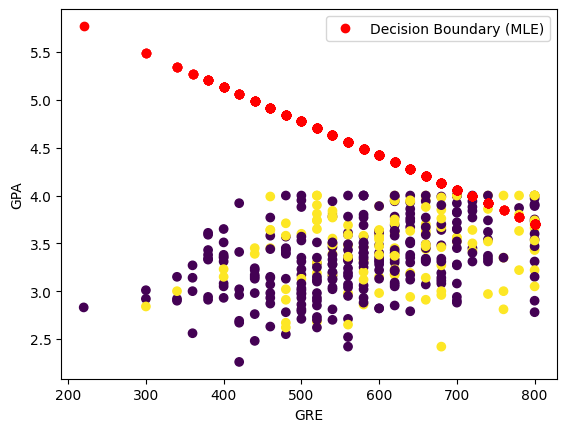

In [ ]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import files

# Load data
fisier=files.upload()
df = pd.read_csv('Admission.csv')

df['intercept'] = 1.0

# Define predictors and response variable
X = df[['intercept', 'GRE', 'GPA']]
y = df['Admission']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0)

# Display model summary
print(result.summary())

# Plot decision boundary
b0, b1, b2 = result.params
decision_boundary = -(b0 + b1 * df['GRE']) / b2

# Plot decision boundary
plt.scatter(df['GRE'], df['GPA'], c=df['Admission'], cmap='viridis')
plt.plot(df['GRE'], decision_boundary, 'ro', label='Decision Boundary (MLE)')
plt.xlabel('GRE')
plt.ylabel('GPA')
plt.legend()
plt.show()

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Load data
fisier=files.upload()
# 1)
data = pd.read_csv('Admission.csv')
data['GRE_normalized'] = (data['GRE'] - data['GRE'].mean()) / data['GRE'].std()
data['GPA_normalized'] = (data['GPA'] - data['GPA'].mean()) / data['GPA'].std()


with pm.Model() as logistic_model:
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)

    logit_p = beta0 + beta1 * data['GRE_normalized'] + beta2 * data['GPA_normalized']


    admission = pm.Bernoulli('admission', logit_p=logit_p, observed=data['Admission'])


    trace = pm.sample(1000, tune=1000)


beta0_samples = trace['beta0'][:, np.newaxis]
beta1_samples = trace['beta1'][:, np.newaxis]
beta2_samples = trace['beta2'][:, np.newaxis]

    # definim functia logistica inversa
def sigmoid(x, beta0, beta1, beta2):
        return 1 / (1 + np.exp(-(beta0 + beta1 * x[0] + beta2 * x[1])))

    # generam gridul pt a reprezenta zona de decizie
gre_values = np.linspace(data['GRE_normalized'].min(), data['GRE_normalized'].max(), 100)
gpa_values = np.linspace(data['GPA_normalized'].min(), data['GPA_normalized'].max(), 100)
grid = np.array(np.meshgrid(gre_values, gpa_values)).T.reshape(-1, 2)

    # calc prob si reprezentam zona de decizie
probabilities = np.mean(np.exp(sigmoid(grid.T, beta0_samples, beta1_samples, beta2_samples)), axis=0)
probabilities_matrix = probabilities.reshape(len(gre_values), len(gpa_values))

plt.figure(figsize=(10, 8))
plt.scatter(data['GRE_normalized'], data['GPA_normalized'], c=data['Admission'], cmap='viridis', alpha=0.8)
contour = plt.contour(gre_values, gpa_values, probabilities_matrix, levels=[0.5], colors='red')
plt.clabel(contour, inline=True, fontsize=12, fmt='Decision Boundary')

plt.xlabel('GRE Normalized')
plt.ylabel('GPA Normalized')
plt.title('Logistic Regression Decision Boundary')
plt.show()

#3)
new_student_data = {'GRE_normalized': (550 - data['GRE'].mean()) / data['GRE'].std(),
                    'GPA_normalized': (3.5 - data['GPA'].mean()) / data['GPA'].std()}


with logistic_model:
    post_pred = pm.sample_posterior_predictive(trace, samples=5000, var_names=['admission'], model=logistic_model)

admission_probabilities = np.mean(post_pred['admission'], axis=0)
prob_interval_90 = np.percentile(admission_probabilities, [5, 95])

print(f'Intervalul de 90% HDI pentru probabilitatea de admitere: {prob_interval_90}')

# 4)
new_student_data_2 = {'GRE_normalized': (500 - data['GRE'].mean()) / data['GRE'].std(),
                      'GPA_normalized': (3.2 - data['GPA'].mean()) / data['GPA'].std()}


with logistic_model:
    post_pred_2 = pm.sample_posterior_predictive(trace, samples=5000, var_names=['admission'], model=logistic_model)

admission_probabilities_2 = np.mean(post_pred_2['admission'], axis=0)
prob_interval_90_2 = np.percentile(admission_probabilities_2, [5, 95])

print(f'Intervalul de 90% HDI pentru probabilitatea de admitere pentru al doilea student: {prob_interval_90_2}')

FileNotFoundError: ignored